Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.
类别索引映射: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Class plastic: 394 samples
Class cardboard: 320 samples
Class metal: 332 samples
Class paper: 470 samples
Class glass: 398 samples
Class trash: 108 samples
Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 43s 602ms/step - accuracy: 0.3605 - loss: 2.0489 - val_accuracy: 0.7390 - val_loss: 1.0268
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 37s 585ms/step - accuracy: 0.6529 - loss: 1.1488 - val_accuracy: 0.8032 - val_loss: 0.7986
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 38s 587ms/step - accuracy: 0.7254 - loss: 0.9917 - val_accuracy: 0.8153 - val_loss: 0.7485
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 37s 586ms/step - accuracy: 0.7265 - loss: 0.9768 - val_accuracy: 0.8474 - val_loss: 0.7135
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 37s 584ms/step - accuracy: 0.7651 - loss: 0.8760 - val_accuracy: 0.7952 - va

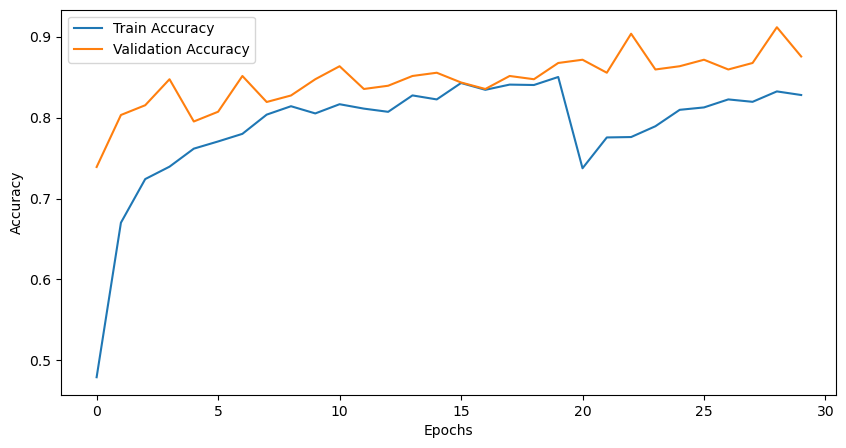

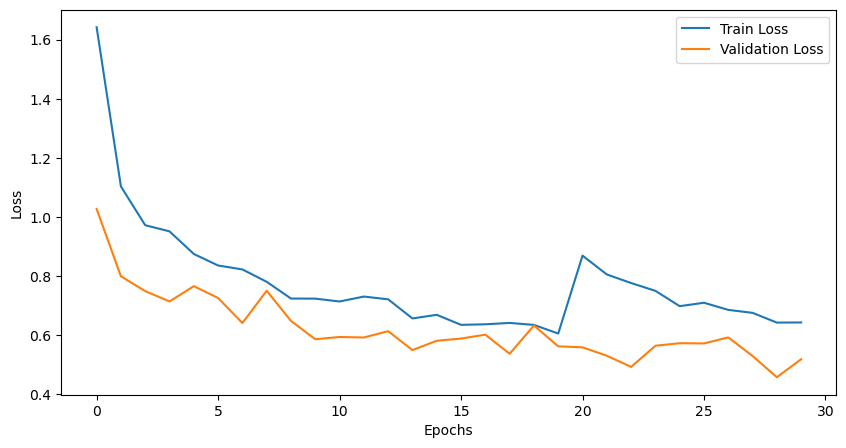

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 533ms/step - accuracy: 0.8465 - loss: 0.6184
测试集准确率: 0.8711
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 510ms/step
              precision    recall  f1-score   support

   cardboard     0.1111    0.1429    0.1250        28
       glass     0.2545    0.2414    0.2478        58
       metal     0.0488    0.0500    0.0494        40
       paper     0.3382    0.3286    0.3333        70
     plastic     0.1591    0.1707    0.1647        41
       trash     0.0833    0.0526    0.0645        19

    accuracy                         0.1992       256
   macro avg     0.1658    0.1644    0.1641       256
weighted avg     0.2016    0.1992    0.1998       256

Model saved successfully!


In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import classification_report
import numpy as np

# 数据加载
batch_size = 32
img_size = (224, 224)

dataset_path = "../dataset/Garbage classification/Garbage classification"

# 划分数据集（训练集80%，验证集10%，测试集10%）
train_dataset = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

val_dataset = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

# 额外划分测试集（从验证集中拆分 50%）
val_batches = len(val_dataset)
test_size = val_batches // 2
test_dataset = val_dataset.take(test_size)
val_dataset = val_dataset.skip(test_size)

# 打印类别索引映射
class_names = train_dataset.class_names
print(f"类别索引映射: {class_names}")

# 统计训练数据中每个类别的样本数量
class_counts = Counter()
for images, labels in train_dataset:
    class_counts.update(labels.numpy())

# 打印类别分布
for class_idx, count in class_counts.items():
    print(f"Class {class_names[class_idx]}: {count} samples")

# 数据增强
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3),
    layers.RandomContrast(0.3),
    layers.RandomBrightness(0.2),
])

# 加载预训练模型
base_model = keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # 冻结特征提取层

# 构建分类模型
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(6, activation="softmax")(x)
model = keras.Model(inputs, outputs)

# 编译模型
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# 训练模型（第一阶段）
epochs = 20
history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs)

# 解冻更多层，进行微调（解冻 MobileNetV2 的后 50 层）
base_model.trainable = True
for layer in base_model.layers[:100]:  # 仅解冻后半部分层
    layer.trainable = False

# 重新编译模型
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# 训练模型（微调阶段）
fine_tune_epochs = 10
history_fine = model.fit(train_dataset, validation_data=val_dataset, epochs=fine_tune_epochs)

# 绘制训练曲线
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'] + history_fine.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 测试集评估
test_loss, test_acc = model.














evaluate(test_dataset)
print(f"测试集准确率: {test_acc:.4f}")

# 获取真实标签和预测标签
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred = np.argmax(model.predict(test_dataset), axis=1)

# 生成完整分类报告（包含 F1-score、Recall、Precision）
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)

# 保存模型
model.save("classification_model.keras")
print("Model saved successfully!")
